In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Reading in the data and getting an overview

In [2]:
# Starting with 10k observations that have NA values filled from KNN imputation
df0 = pd.read_csv('na_filled_df.csv')
df0 = df0.sample(n=35000, random_state=2025)
df = df0
df.shape

(35000, 81)

In [3]:
print(df.head())
df.columns

       activity_year  derived_msa-md  county_code  census_tract  action_taken  \
47390         2019.0         19740.0       8005.0  8.005006e+09           1.0   
38566         2019.0             0.0      60195.0  6.019502e+10           5.0   
32814         2019.0         99999.0      55115.0  5.511510e+10           1.0   
41393         2019.0         46340.0      48423.0  4.842300e+10           4.0   
12564         2019.0         99999.0      27115.0  2.711595e+10           6.0   

       purchaser_type  preapproval  loan_type  loan_purpose  lien_status  ...  \
47390            71.0          2.0        1.0           1.0          1.0  ...   
38566             0.0          2.0        2.0           1.0          1.0  ...   
32814             0.0          2.0        1.0          32.0          1.0  ...   
41393             0.0          2.0        1.0          32.0          1.0  ...   
12564             2.0          2.0        3.0           1.0          1.0  ...   

       derived_loan_produc

Index(['activity_year', 'derived_msa-md', 'county_code', 'census_tract',
       'action_taken', 'purchaser_type', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'income',
       'debt_to_income_ratio', 'applicant_credit_score_type',
       'co-applicant_credit_score_type', 'applicant_ethnicity-1',
       'applicant_ethnicity-2', 'co-applicant_ethnicity-1',
    

action_taken
1.0    53.288571
3.0    14.080000
6.0    13.142857
4.0    12.297143
5.0     4.060000
2.0     2.194286
8.0     0.482857
7.0     0.454286
Name: count, dtype: float64


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='action_taken', ylabel='count'>

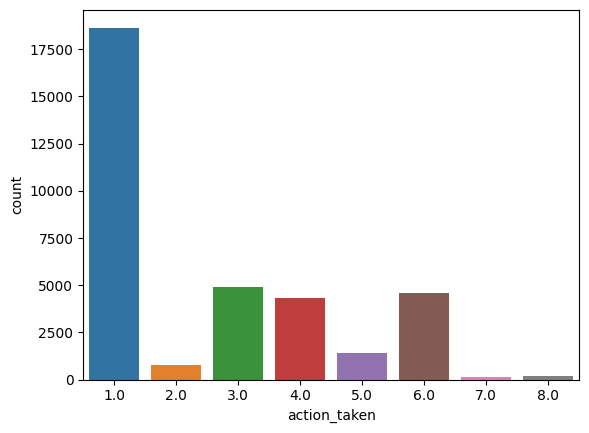

In [4]:
# Looking at the percentage of each action type
print(df['action_taken'].value_counts()/len(df)*100)
sns.countplot(x='action_taken', data=df)

In [5]:
# Converting target variable to binary
df['action_taken'] = df['action_taken'].apply(lambda x: 1 if x in [1,2,6] else 0)

****

### Data cleaning and feature selection

In [6]:
columns_to_select = ['action_taken', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'preapproval', 'property_value',
                     'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
                     'loan_term', 'negative_amortization', 'occupancy_type', 'income', 'debt_to_income_ratio']
df0 = df[columns_to_select]
df0.shape

(35000, 18)

In [7]:
# Finding categorical variables
string_columns = df0.select_dtypes(include=['object']).columns
string_df = df0[string_columns]
print(string_columns)

Index(['conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category'],
      dtype='object')


In [8]:
# Seeing how many unique values each category has
unique_counts = {}

for column in string_columns:
    unique_counts[column] = df[column].nunique()

unique_counts

{'conforming_loan_limit': 3,
 'derived_loan_product_type': 6,
 'derived_dwelling_category': 3}

In [9]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)
df_dummies = pd.get_dummies(df0, columns=string_columns, drop_first=True)
df_dummies.shape

(35000, 24)

## Building a random forest model

In [10]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

In [12]:
# Building the random forest model
np.random.seed(2023)
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = rf0.predict(X_test)

In [ ]:
# Saving predictions to a csv file

# Ensure consistent indices after splitting (if not already done)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 1. Test Data with Predictions
test_data_with_predictions = X_test.copy()
test_data_with_predictions['actual'] = y_test
test_data_with_predictions['predictions'] = y_pred

# 2. Combined Train and Test Data with Predictions
# Reset index for training data if necessary
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

train_data_with_predictions = X_train.copy()
train_data_with_predictions['actual'] = y_train
# Generate predictions for the training data
train_data_with_predictions['predictions'] = rf0.predict(X_train)

# Concatenating the train and test data
combined_data_with_predictions = pd.concat([train_data_with_predictions, test_data_with_predictions], ignore_index=True)

# Saving to a csv
test_data_with_actual.to_csv('test_set_predictions.csv')
combined_data_with_predictions.to_csv('full_set_predictions.csv')

Accuracy: 0.7367
Precision: 0.7638
Recall: 0.8887
F1 Score: 0.8215
Confusion Matrix:


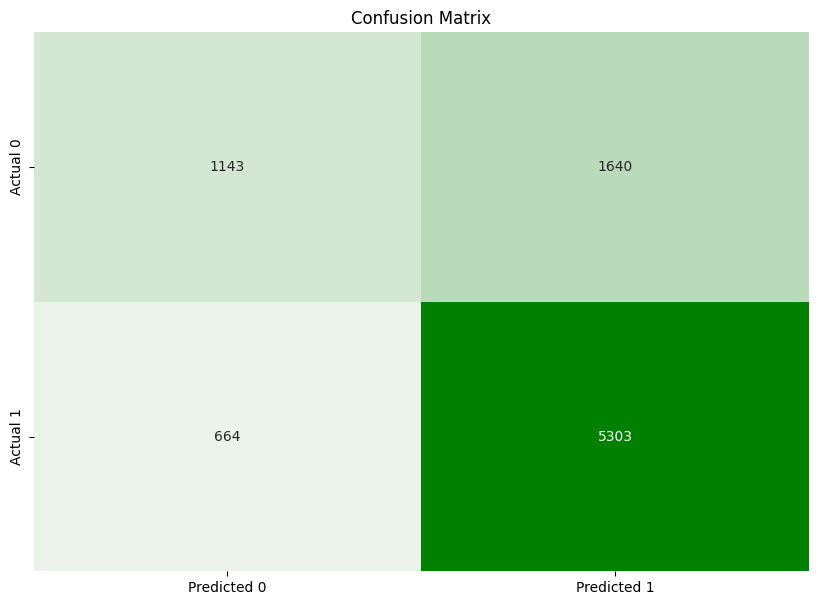

In [14]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

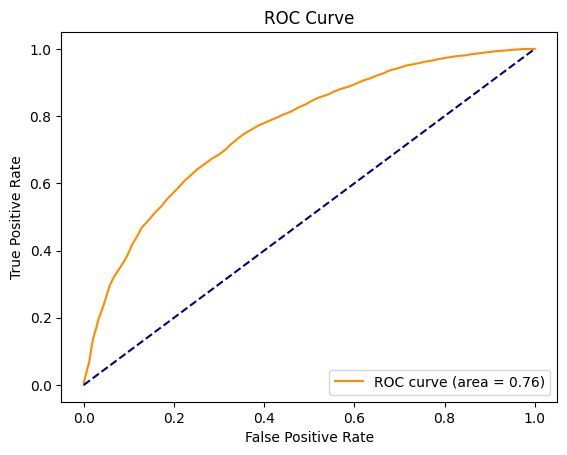

In [12]:
# Plotting the ROC curve
y_prob = rf0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

In [13]:
importances = rf0.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [X.columns[idx] for idx in sorted_indices]

sorted_features_with_importance = []
for i, idx in enumerate(sorted_indices):
    feature_name = X.columns[idx]
    importance_value = importances[idx]
    print(f"{i + 1}. {feature_name} ({importance_value})")
    sorted_features_with_importance.append((feature_name, importance_value))

1. loan_to_value_ratio (0.19917212545910773)
2. income (0.18089841400467685)
3. property_value (0.16358140770166)
4. debt_to_income_ratio (0.14166893236536704)
5. loan_amount (0.12799526250198823)
6. loan_purpose (0.05246025423115661)
7. loan_term (0.044391264242477614)
8. derived_loan_product_type_FHA:First Lien (0.01215329933785671)
9. occupancy_type (0.011332177718053919)
10. open-end_line_of_credit (0.010906511286483686)
11. derived_loan_product_type_VA:First Lien (0.00976999126287333)
12. derived_dwelling_category_Single Family (1-4 Units):Manufactured (0.006550934235321358)
13. derived_dwelling_category_Single Family (1-4 Units):Site-Built (0.006339899437561954)
14. preapproval (0.006056846821347344)
15. business_or_commercial_purpose (0.005901095869259614)
16. derived_loan_product_type_Conventional:Subordinate Lien (0.004380466023985573)
17. lien_status (0.004001367634797691)
18. reverse_mortgage (0.0032124002501925653)
19. conforming_loan_limit_NC (0.0031061361840767133)
20. ne

In [14]:
""" # # Getting shapley values
# # Initializing SHAP explainer
explainer = shap.TreeExplainer(rf0)

# Compute Shapley values for the test set
shap_values = explainer.shap_values(X_test)

# Visualization of SHAP values
shap.summary_plot(shap_values, X_test) """

' # # Getting shapley values\n# # Initializing SHAP explainer\nexplainer = shap.TreeExplainer(rf0)\n\n# Compute Shapley values for the test set\nshap_values = explainer.shap_values(X_test)\n\n# Visualization of SHAP values\nshap.summary_plot(shap_values, X_test) '

****

## Looking into metrics with Microsoft Fairlearn

In [14]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

In [ ]:
# Here is some code to check if the indices match for sensitive_features_test and y_test and y_pred

""" # Convert y_pred to a pandas Series if it's not already
if not isinstance(y_pred, pd.Series):
    y_pred_series = pd.Series(y_pred, index=y_test.index)
else:
    y_pred_series = y_pred
# Check if indices match
indices_match_y_test_y_pred = all(y_test.index == y_pred_series.index)
indices_match_y_test_sensitive = all(y_test.index == sensitive_features_test.index)

# Print results
if indices_match_y_test_y_pred:
    print("Indices of y_test and y_pred match.")
else:
    print("Indices of y_test and y_pred do NOT match.")

if indices_match_y_test_sensitive:
    print("Indices of y_test and sensitive_features_test match.")
else:
    print("Indices of y_test and sensitive_features_test do NOT match.") """

In [15]:
# Changing the labels on 'applicant_sex' to make it more readable in the visualizations

sensitive_features_test['applicant_sex'] = sensitive_features_test['applicant_sex'].astype(float).astype(int)

# Transform values that aren't 1 or 2 to 3
sensitive_features_test['applicant_sex'] = sensitive_features_test['applicant_sex'].apply(lambda x: x if x in [1, 2] else 3)

# Map the integer values to their corresponding string representation
gender_mapping = {
    1: 'Male',
    2: 'Female',
    3: 'Other/NA'
}
sensitive_features_test['applicant_sex'] = sensitive_features_test['applicant_sex'].map(gender_mapping)


sensitive_features_test

,applicant_sex,applicant_age_above_62,derived_race
43867,Female,No,White
27739,Male,No,White
10689,Female,No,White
687,Female,No,White
16423,Female,No,White
...,...,...,...
38764,Other/NA,nan,Race Not Available
13546,Female,No,White
12498,Male,No,White
45317,Other/NA,No,Race Not Available


In [16]:
# Accuracy by race
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(mf.overall)
mf.by_group

0.7366857142857143


DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


derived_race
2 or more minority races                     0.900000
American Indian or Alaska Native             0.722222
Asian                                        0.695652
Black or African American                    0.646320
Joint                                        0.697143
Native Hawaiian or Other Pacific Islander    0.875000
Race Not Available                           0.756650
White                                        0.742200
Name: accuracy_score, dtype: float64

In [17]:
# Selection rate is the percentage of the population that is labeled '1'
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(sr.overall)
sr.by_group

0.7934857142857142


DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


derived_race
2 or more minority races                     0.600000
American Indian or Alaska Native             0.777778
Asian                                        0.828375
Black or African American                    0.712747
Joint                                        0.811429
Native Hawaiian or Other Pacific Islander    0.541667
Race Not Available                           0.802463
White                                        0.796570
Name: selection_rate, dtype: float64

In [18]:
# Manually defining positives and negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

### Applicant sex

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


array([[<Axes: title={'center': 'accuracy'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'precision'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'recall'}, xlabel='applicant_sex'>],
       [<Axes: title={'center': 'F1 score'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='applicant_sex'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'count'}, xlabel='applicant_sex'>,
        <Axes: xlabel='applicant_sex'>]], dtype=object)

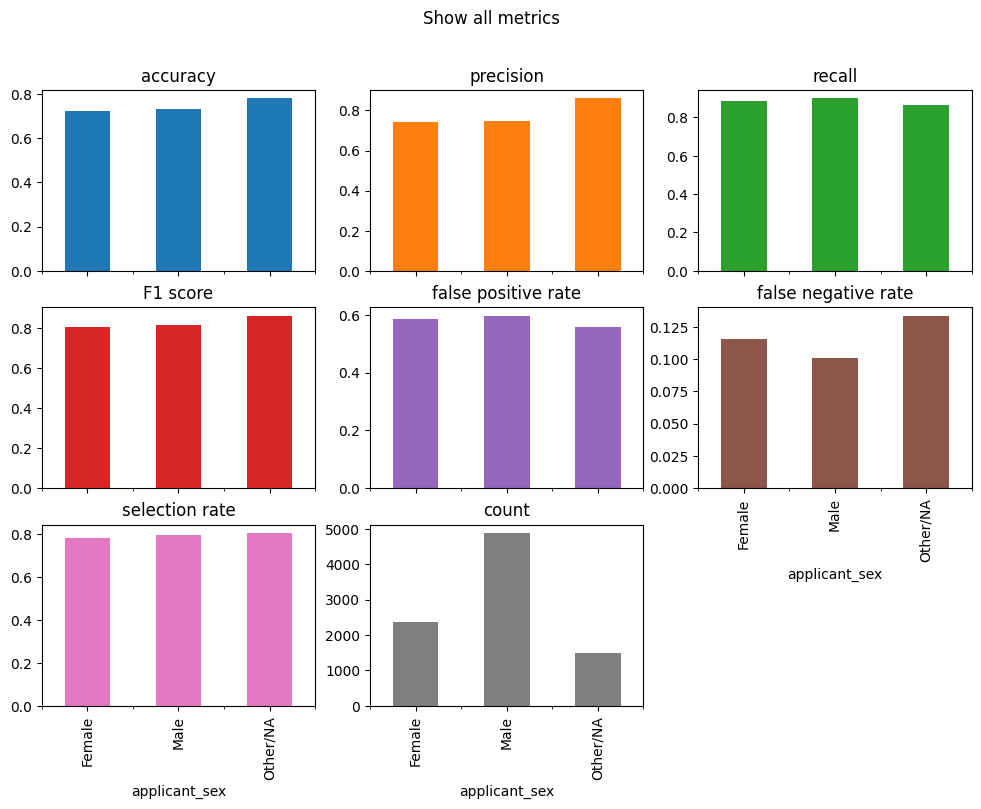

In [21]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "F1 score": f1_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_sex'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [22]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

               accuracy  precision  recall  F1 score  false positive rate  \
applicant_sex                                                               
Female            0.721      0.740   0.884     0.806                0.586   
Male              0.731      0.745   0.899     0.815                0.597   
Other/NA          0.781      0.860   0.866     0.863                0.558   

               false negative rate  selection rate   count  
applicant_sex                                               
Female                       0.116           0.781  2380.0  
Male                         0.101           0.796  4878.0  
Other/NA                     0.134           0.804  1492.0  


In [25]:
from scipy.stats import ttest_ind

# Get the unique groups
unique_groups = np.unique(sensitive_features_test['applicant_sex'].values)

# Compute F1 scores for each group and store them in a dictionary
f1_scores = {}
for group in unique_groups:
    indices = np.where(sensitive_features_test['applicant_sex'].values == group)[0]
    f1_scores[group] = f1_score(y_test.iloc[indices], y_pred[indices])

# Print the F1 scores for each group
for group, score in f1_scores.items():
    print(f"F1 score for group {group}: {score:.3f}")

# Perform pairwise t-tests between the groups
for i in range(len(unique_groups)):
    for j in range(i+1, len(unique_groups)):
        group_i = unique_groups[i]
        group_j = unique_groups[j]
        
        indices_i = np.where(sensitive_features_test['applicant_sex'].values == group_i)[0]
        indices_j = np.where(sensitive_features_test['applicant_sex'].values == group_j)[0]
        
        t_stat, p_value = ttest_ind(y_pred[indices_i], y_pred[indices_j])
        
        print(f"\nT-test between group {group_i} and group {group_j}:")
        print(f"T-statistic: {t_stat:.3f}")
        print(f"P-value: {p_value:.3f}")


F1 score for group Female: 0.806
F1 score for group Male: 0.815
F1 score for group Other/NA: 0.863

T-test between group Female and group Male:
T-statistic: -1.490
P-value: 0.136

T-test between group Female and group Other/NA:
T-statistic: -1.725
P-value: 0.085

T-test between group Male and group Other/NA:
T-statistic: -0.679
P-value: 0.497


### Applicant race

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


array([[<Axes: title={'center': 'accuracy'}, xlabel='derived_race'>,
        <Axes: title={'center': 'precision'}, xlabel='derived_race'>,
        <Axes: title={'center': 'recall'}, xlabel='derived_race'>],
       [<Axes: title={'center': 'F1 score'}, xlabel='derived_race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='derived_race'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'count'}, xlabel='derived_race'>,
        <Axes: xlabel='derived_race'>]], dtype=object)

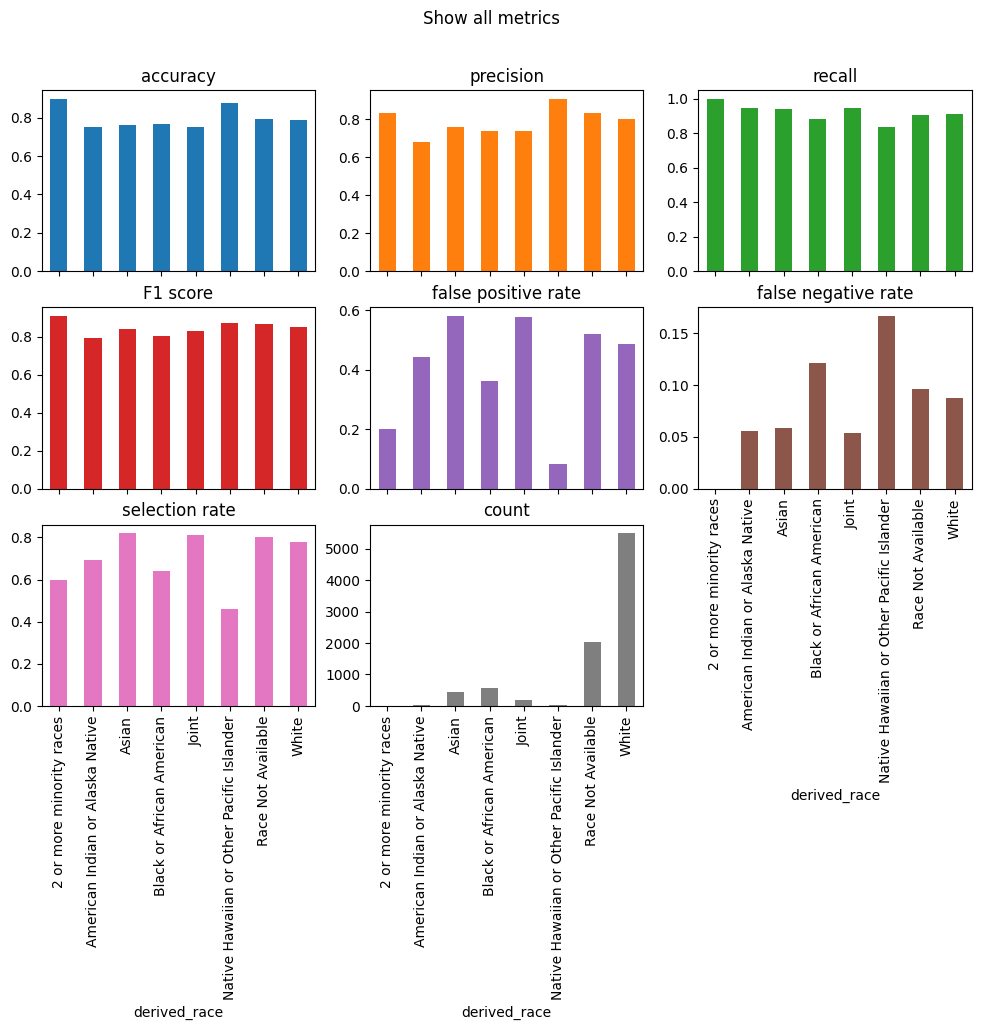

In [22]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [23]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

                                           accuracy  precision  recall  \
derived_race                                                             
2 or more minority races                      0.900      0.833   1.000   
American Indian or Alaska Native              0.750      0.680   0.944   
Asian                                         0.764      0.760   0.941   
Black or African American                     0.767      0.736   0.879   
Joint                                         0.754      0.739   0.946   
Native Hawaiian or Other Pacific Islander     0.875      0.909   0.833   
Race Not Available                            0.793      0.831   0.904   
White                                         0.786      0.801   0.913   

                                           F1 score  false positive rate  \
derived_race                                                               
2 or more minority races                      0.909                0.200   
American Indian or Alaska Nativ

### Applicant age above 62

DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


array([[<Axes: title={'center': 'accuracy'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'precision'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'recall'}, xlabel='applicant_age_above_62'>],
       [<Axes: title={'center': 'F1 score'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='applicant_age_above_62'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'count'}, xlabel='applicant_age_above_62'>,
        <Axes: xlabel='applicant_age_above_62'>]], dtype=object)

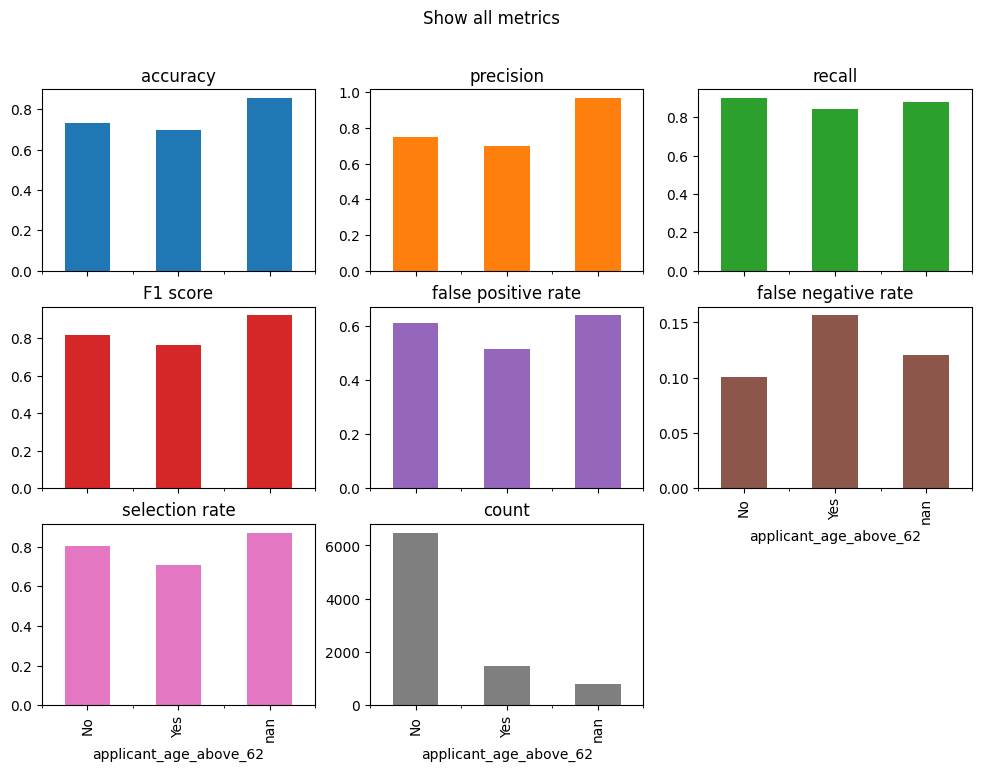

In [26]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, 
    y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [27]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

                        accuracy  precision  recall  F1 score  \
applicant_age_above_62                                          
No                         0.731      0.750   0.899     0.818   
Yes                        0.695      0.700   0.844     0.765   
nan                        0.856      0.967   0.879     0.921   

                        false positive rate  false negative rate  \
applicant_age_above_62                                             
No                                    0.609                0.101   
Yes                                   0.516                0.156   
nan                                   0.639                0.121   

                        selection rate   count  
applicant_age_above_62                          
No                               0.804  6471.0  
Yes                              0.709  1480.0  
nan                              0.869   799.0  


In [26]:
""" # Getting errors for race and sex metrics. It seems that some groups are too small and causing errors.
print(df['derived_race'].value_counts()/len(df)*100)
sns.countplot(x='derived_race', data=df) """

" # Getting errors for race and sex metrics. It seems that some groups are too small and causing errors.\nprint(df['derived_race'].value_counts()/len(df)*100)\nsns.countplot(x='derived_race', data=df) "

### Updating the objective function with Exponentiated Gradient mitigation  using Demographic Parity as the objective

In [44]:
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient

In [46]:
np.random.seed(2023)

constraint = EqualizedOdds()
classifier = RandomForestClassifier(n_estimators=100, random_state=2023)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_features_train['applicant_sex'])

y_pred_mitigated = mitigator.predict(X_test)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

In [ ]:
# Old cold using demographic parity as a constraint
""" np.random.seed(2023)

constraint = DemographicParity()
classifier = RandomForestClassifier(n_estimators=100, random_state=2023)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_features_train['applicant_age_above_62'])

y_pred_mitigated = mitigator.predict(X_test) """

""" # Getting mitigated selection rate
sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=sensitive_features_test['applicant_age_above_62'])
print(f"Mitigated selction rate overall {sr_mitigated.overall.round(3)}")
print(f"Mitigated selction rate by age group {sr_mitigated.by_group.round(3)}")

# Comparing mitigated selection rate above to normal selection rate
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])
print(f"Original selection rate overall {sr.overall.round(3)}")
print(f"Originanl selction rate by age group {sr.by_group.round(3)}") """

### Comparing mitigated to original

In [60]:
# Define the metrics
metrics_list = ['false_positive_rate', 'false_negative_rate', 'f1_score']

# Initialize an empty dictionary to hold the metrics
metrics_dict = {
    'FPR Male': [],
    'FPR Female': [],
    'FPR Other/NA': [],
    'FNR Male': [],
    'FNR Female': [],
    'FNR Other/NA': [],
    'F1 Male': [],
    'F1 Female': [],
    'F1 Other/NA': []
}

# Populate the dictionary with the metric values for mitigated and original models
for metric_name in metrics_list:
    for group in ['Male', 'Female', 'Other/NA']:
        mitigated_metric = metric_frame_mitigated.by_group[metric_name][group].round(3) if metric_name in metric_frame_mitigated.by_group else None
        original_metric = metric_frame_original.by_group[metric_name][group].round(3) if metric_name in metric_frame_original.by_group else None
        key_suffix = 'FPR' if metric_name == 'false_positive_rate' else 'FNR' if metric_name == 'false_negative_rate' else 'F1'
        metrics_dict[f'{key_suffix} {group}'].append(mitigated_metric)
        metrics_dict[f'{key_suffix} {group}'].append(original_metric)

# Create the DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Mitigated', 'Original'])

# Display the DataFrame
print(metrics_df)

           FPR Male  FPR Female  FPR Other/NA  FNR Male  FNR Female  \
Mitigated     0.584       0.573         0.565     0.102       0.114   
Original      0.597       0.586         0.558     0.101       0.116   

           FNR Other/NA  F1 Male  F1 Female  F1 Other/NA  
Mitigated         0.129    0.817      0.810        0.865  
Original          0.134    0.815      0.806        0.863  


In [62]:
# Define the metrics
metrics = {
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'f1_score': f1_score,
}

# Calculate metrics for the mitigated model
metric_frame_mitigated = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred_mitigated,
                                     sensitive_features=sensitive_features_test['applicant_sex'])

# Calculate metrics for the original model
metric_frame_original = MetricFrame(metrics=metrics,
                                    y_true=y_test,
                                    y_pred=y_pred,
                                    sensitive_features=sensitive_features_test['applicant_sex'])

# Create a dictionary to hold the overall metrics for mitigated and original models
overall_metrics_dict = {
    'FPR': [
        metric_frame_mitigated.overall['false_positive_rate'].round(3),
        metric_frame_original.overall['false_positive_rate'].round(3)
    ],
    'FNR': [
        metric_frame_mitigated.overall['false_negative_rate'].round(3),
        metric_frame_original.overall['false_negative_rate'].round(3)
    ],
    'F1 Score': [
        metric_frame_mitigated.overall['f1_score'].round(3),
        metric_frame_original.overall['f1_score'].round(3)
    ]
}

# Create the DataFrame with 'Mitigated' and 'Original' as the index
overall_metrics_df = pd.DataFrame(overall_metrics_dict, index=['Mitigated', 'Original'])

# Display the DataFrame
print('Overall metrics')
print(overall_metrics_df)


Overall metrics
             FPR    FNR  F1 Score
Mitigated  0.579  0.110     0.824
Original   0.589  0.111     0.822


DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
